In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy, random, os,colorsys

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import poisson, chisquare
from scipy.stats import mode
import os, joblib
from joblib import Parallel, delayed
import scanpy as sc

sc._settings.ScanpyConfig.n_jobs = os.cpu_count() - 1

In [2]:
adata = sc.read_h5ad('./data/HICA2022_BM.h5ad')
adata

AnnData object with n_obs × n_vars = 266271 × 26911
    obs: 'n_genes', 'Channel', 'n_counts', 'percent_mito', 'scale', 'Group', 'leiden_labels', 'Donor', 'doublet_score', 'pred_dbl', 'leiden_labels_split', 'anno'
    var: 'featureid', 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    uns: 'Channels', 'Groups', 'PCs', 'W_pca_harmony', 'c2gid', 'df_qcplot', 'genome', 'gncells', 'leiden_resolution', 'modality', 'ncells', 'norm_count', 'pca', 'pca_features', 'pca_harmony_knn_distances', 'pca_harmony_knn_indices', 'stdzn_max_value', 'stdzn_mean', 'stdzn_std'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'de_res', 'gmeans', 'gstds', 'means', 'partial_sum'

In [3]:
adata.obs['anno'].value_counts()

anno
CD4+ naive T cells           44009
Cytotoxic T cells            39450
CD14+ monocytes              37570
T helper cells               24797
Naive B cells                23515
CD8+ naive T cells           20877
NK cells                     19528
Erythroid cells               8954
Memory B cells                8822
Pre-B cells                   7523
cDCs                          4703
HSCs                          4323
CD16+ monocytes               3807
Neutrophil progenitors        3571
Pro-B cells                   3313
pDCs                          2790
Plasma cells                  2605
Erythroid progenitors         2562
ANK1-low erythroid cells      2552
Megakaryocyte progenitors      719
MSCs                           281
Name: count, dtype: int64

In [4]:
cell_type_to_broad = {
    # T cells
    'CD4+ naive T cells': 'T cells',
    'CD8+ naive T cells': 'T cells',
    'Cytotoxic T cells': 'T cells',
    'T helper cells': 'T cells',
    # B cells
    'Naive B cells': 'B cells',
    'Memory B cells': 'B cells',
    'Pre-B cells': 'B cells',
    'Pro-B cells': 'B cells',
    # Plasma cells
    'Plasma cells': 'Plasma cells',
    # Monocytes
    'CD14+ monocytes': 'Monocytes',
    'CD16+ monocytes': 'Monocytes',
    # Dendritic cells
    'cDCs': 'Dendritic cells',
    'pDCs': 'Dendritic cells',
    # NK cells
    'NK cells': 'NK cells',
    # Erythroid lineage
    'Erythroid cells': 'Erythroid lineage',
    'Erythroid progenitors': 'Erythroid lineage',
    'ANK1-low erythroid cells': 'Erythroid lineage',
    # Myeloid progenitors
    'Neutrophil progenitors': 'Myeloid progenitors',
    'Megakaryocyte progenitors': 'Myeloid progenitors',
    # Stem and stromal
    'HSCs': 'Stem/progenitor cells',
    'MSCs': 'Stem/progenitor cells'
}

# Apply the mapping to your AnnData object
adata.obs['broad_cell_type'] = adata.obs['anno'].map(cell_type_to_broad)

<Axes: title={'center': 'broad_cell_type'}, xlabel='PC1', ylabel='PC2'>

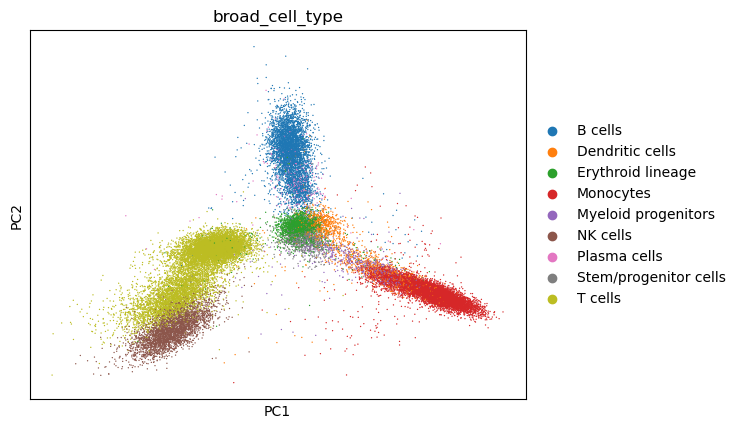

In [15]:
# donor 4,5,8
donor_id = "4"
adata_donor = adata[(adata.obs['Donor'] == donor_id)].copy()
sc.pp.filter_cells(adata_donor, min_genes=500)
sc.pp.filter_genes(adata_donor, min_cells=5)
adata_donor.layers["counts"] = adata_donor.X.copy()
sc.pp.normalize_total(adata_donor, target_sum=1e6) # normalize so that each cell would have the same total counts
sc.pp.log1p(adata_donor)
sc.pp.highly_variable_genes(adata_donor, n_top_genes=1000)
sc.pp.scale(adata_donor)
sc.tl.pca(adata_donor, mask_var="highly_variable", n_comps=200, svd_solver='auto')
sc.pl.pca(adata_donor, color="broad_cell_type",  projection="2d", show=False)

12
0.5940181


Text(0, 0.5, 'Explained Variance')

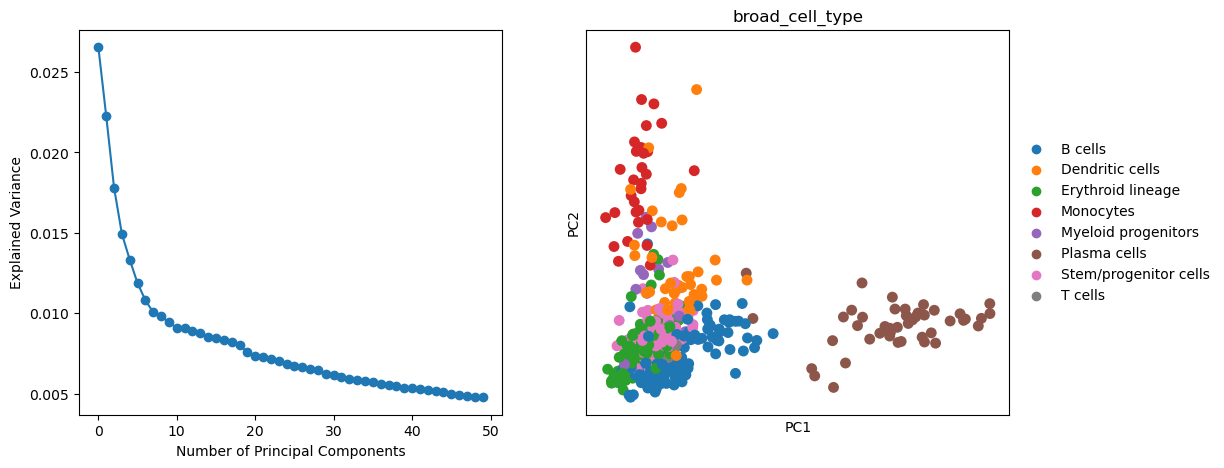

In [16]:
# np.random.seed(0)
global_state_vecs = adata_donor.obsm['X_pca']
random_point = global_state_vecs[np.random.choice(range(len(global_state_vecs)))]
knn = NearestNeighbors(n_neighbors = 500, algorithm='auto')
knn.fit(global_state_vecs)
_, indices = knn.kneighbors([random_point])

adata_donor_subset = adata[(adata.obs['Donor'] == donor_id)]
adata_donor_subset = adata_donor_subset[indices[0]].copy()
adata_donor_subset.layers["counts"] = adata_donor_subset.X.copy()
figure, axes = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.normalize_total(adata_donor_subset, target_sum=1e6) # normalize so that each cell would have the same total counts
sc.pp.log1p(adata_donor_subset)
sc.pp.highly_variable_genes(adata_donor_subset, n_top_genes=1000)
sc.pp.scale(adata_donor_subset)
sc.tl.pca(adata_donor_subset, mask_var="highly_variable", n_comps=100, svd_solver='auto')

center = adata_donor_subset.obsm['X_pca'].mean(axis=0)
dists = np.linalg.norm(adata_donor_subset.obsm['X_pca'] - center, axis=1)
z_threshold = 3
z_scores = (dists - np.mean(dists)) / np.std(dists)
outlier_mask = z_scores > z_threshold
print(np.sum(outlier_mask))
adata_donor_subset = adata_donor_subset[~outlier_mask].copy()  # keep only non-outliers
sc.pl.pca(adata_donor_subset, color="broad_cell_type",  projection="2d", show=False, ax=axes[1])

explained_variance_ratio = adata_donor_subset.uns['pca']['variance_ratio'] 
print(sum(explained_variance_ratio))
axes[0].plot(explained_variance_ratio[:50], marker='o')
axes[0].set_xlabel("Number of Principal Components")
axes[0].set_ylabel("Explained Variance")

In [17]:
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
from scipy.stats import entropy

def extract_mst_features(data):
    dist_matrix = squareform(pdist(data))
    mst_sparse = minimum_spanning_tree(dist_matrix)
    mst_graph = nx.from_scipy_sparse_array(mst_sparse)

    num_nodes = len(mst_graph.nodes)
    # --- Edge lengths ---
    edge_lengths = np.array([d['weight'] for u, v, d in mst_graph.edges(data=True)])
    avg_edge_length = edge_lengths.mean()
    edge_length_std = edge_lengths.std()
    edge_length_cv = edge_length_std / avg_edge_length

    # --- Spectral features ---
    laplacian = nx.laplacian_matrix(mst_graph).todense()
    lap_eigvals = np.linalg.eigvalsh(laplacian)
    spectral_radius = lap_eigvals.max()
    algebraic_connectivity_norm = lap_eigvals[1] / lap_eigvals[-1]
    laplacian_energy = np.sum((lap_eigvals - lap_eigvals.mean())**2)

    # --- Branching structure features ---
    degrees = dict(mst_graph.degree())
    internal_nodes = [n for n, d in degrees.items() if d >= 2]
    internal_degrees = [degrees[n] / num_nodes for n in internal_nodes]
    branching_factor_mean = np.mean(internal_degrees) if internal_degrees else 0
    branching_factor_std = np.std(internal_degrees) if internal_degrees else 0
    proportion_leaf_nodes = np.sum(degrees == 1) / num_nodes
    leaf_nodes = [n for n, d in mst_graph.degree() if d == 1]
    branching_index = (num_nodes - len(leaf_nodes)) / len(leaf_nodes)
    degrees = np.array([deg for _, deg in mst_graph.degree()])
    unique_degrees, counts = np.unique(degrees, return_counts=True)
    degree_probs = counts / counts.sum()
    degree_entropy = entropy(degree_probs)

    mst_features = {
        'edge_length_cv': edge_length_cv,
        'algebraic_connectivity_norm': algebraic_connectivity_norm,
        'laplacian_energy_norm': laplacian_energy / num_nodes,
        'branching_factor_mean': branching_factor_mean , 
        'branching_factor_std': branching_factor_std,
        "proportion_leaf_nodes": proportion_leaf_nodes,
        "degree_entropy": degree_entropy,
        "branching_index": branching_index,
    }
    return mst_features

def FPC_radius_based(X):
    nbrs = NearestNeighbors(n_neighbors=100).fit(X)
    distances, _ = nbrs.kneighbors(X)
    density = -distances[:, 1:].mean(axis=1)
    centers = [np.argmax(density)]
    distances = pairwise_distances(X, X[centers[-1]].reshape(1, -1)).flatten()
    dists = pairwise_distances(X)
    min_dist_threshold = np.percentile(dists, 25)
    while True:
        next_center = np.argmax(distances)
        max_dist = distances[next_center]
        if max_dist < min_dist_threshold:
            break
        centers.append(next_center)
        new_distances = pairwise_distances(X, X[next_center].reshape(1, -1)).flatten()
        distances = np.minimum(distances, new_distances)
    center_points = X[centers]
    labels = np.argmin(pairwise_distances(X, center_points), axis=1)
    print("Number of clusters:", len(centers))
    return centers, labels

def extract_population_feature_dict(PCs): 
    def linear_regression_test(x, y):
        slope, intercept = np.polyfit(x, y, 1)
        y_pred = slope * x + intercept
        residuals = y - y_pred
        se_res = np.sqrt(np.sum(residuals**2) / (len(x) - 2))
        Sxx = np.sum((x - np.mean(x)) ** 2)
        slope_se = se_res / np.sqrt(Sxx)
        t_stat = slope / slope_se
        return [slope, slope_se, t_stat]

    cluster_centers, cluster_labels = FPC_radius_based(PCs)
    sorted_abundance = np.array(sorted(np.unique(cluster_labels, return_counts=True)[1], reverse=True))
    ranks = np.arange(1, len(sorted_abundance) + 1)
    log_abundance = np.log(sorted_abundance)
    log_ranks = np.log(ranks)

    feature_dict = {}
    feature_dict = extract_mst_features(PCs) 
    # Fit power law
    slope, slope_se, t_stat = linear_regression_test(log_ranks, log_abundance)
    feature_dict['FPC_loglog_slope'] = slope
    # Fit exponential
    slope, slope_se, t_stat = linear_regression_test(ranks, log_abundance)
    feature_dict['FPC_logy_slope'] = slope
    # n1 / n2
    feature_dict['FPC_n1n2'] = sorted_abundance[0] / sorted_abundance[1]
    feature_dict['FPC_n_clusters'] = len(sorted_abundance)
    return feature_dict

In [18]:
# %%capture
rf_model = joblib.load('../simulation/data/rf_model.pkl')

chosen_indices = []
pred_labels = []
confidence_scores = []
n_clusters = []
for _ in range(100):
    chosen_indices.append(np.random.choice(range(len(global_state_vecs))))
    random_point = global_state_vecs[chosen_indices[-1]]
    # knn
    knn = NearestNeighbors(n_neighbors = 1000, algorithm='auto')
    knn.fit(global_state_vecs)
    distances, indices = knn.kneighbors([random_point])

    adata_donor_subset = adata[(adata.obs['Donor'] == donor_id)]
    adata_donor_subset = adata_donor_subset[indices[0]].copy()
    adata_donor_subset.layers["counts"] = adata_donor_subset.X.copy()
    sc.pp.normalize_total(adata_donor_subset, target_sum=1e6) # normalize so that each cell would have the same total counts
    sc.pp.log1p(adata_donor_subset)
    sc.pp.highly_variable_genes(adata_donor_subset, n_top_genes=2000)
    sc.pp.scale(adata_donor_subset)
    sc.tl.pca(adata_donor_subset, mask_var="highly_variable", n_comps=20, svd_solver='auto')

    pcs = adata_donor_subset.obsm['X_pca']
    center = pcs.mean(axis=0)
    dists = np.linalg.norm(pcs - center, axis=1)
    z_threshold = 3
    z_scores = (dists - np.mean(dists)) / np.std(dists)
    outlier_mask = z_scores > z_threshold
    adata_donor_subset = adata_donor_subset[~outlier_mask].copy()  # keep only non-outliers

    feature_dict = extract_population_feature_dict(adata_donor_subset.obsm['X_pca'])
    input_vec = np.array([feature_dict[k] for k in sorted(feature_dict.keys())])
    pred_labels.append(rf_model.predict([input_vec])[0])
    all_tree_probs = np.array([tree.predict_proba([input_vec]) for tree in rf_model.estimators_])
    tree_preds = np.array([np.argmax(probs) for probs in all_tree_probs])  # shape: [n_trees]
    consensus_label, count = mode(tree_preds, keepdims=False)
    percentage_votes = np.sum(tree_preds == consensus_label) / len(rf_model.estimators_)
    confidence_scores.append(percentage_votes)
    n_clusters.append(feature_dict['FPC_n_clusters'])

Number of clusters: 106
Number of clusters: 275
Number of clusters: 258
Number of clusters: 237
Number of clusters: 254
Number of clusters: 167
Number of clusters: 234
Number of clusters: 272
Number of clusters: 65
Number of clusters: 254
Number of clusters: 267
Number of clusters: 286
Number of clusters: 176
Number of clusters: 170
Number of clusters: 276
Number of clusters: 273
Number of clusters: 276
Number of clusters: 248
Number of clusters: 171
Number of clusters: 164
Number of clusters: 255
Number of clusters: 104
Number of clusters: 260
Number of clusters: 229
Number of clusters: 281
Number of clusters: 277
Number of clusters: 253
Number of clusters: 195
Number of clusters: 218
Number of clusters: 155
Number of clusters: 277
Number of clusters: 100
Number of clusters: 243
Number of clusters: 104
Number of clusters: 204
Number of clusters: 202
Number of clusters: 263
Number of clusters: 180
Number of clusters: 262
Number of clusters: 272
Number of clusters: 224
Number of cluster

/tmp/ipykernel_3271/3851015227.py:39: UserWarning: Adding colorbar to a different Figure <Figure size 1440x960 with 5 Axes> than <Figure size 1200x500 with 2 Axes> which fig.colorbar is called on.
  cbar = figure.colorbar(im, ax=axes[1,0])


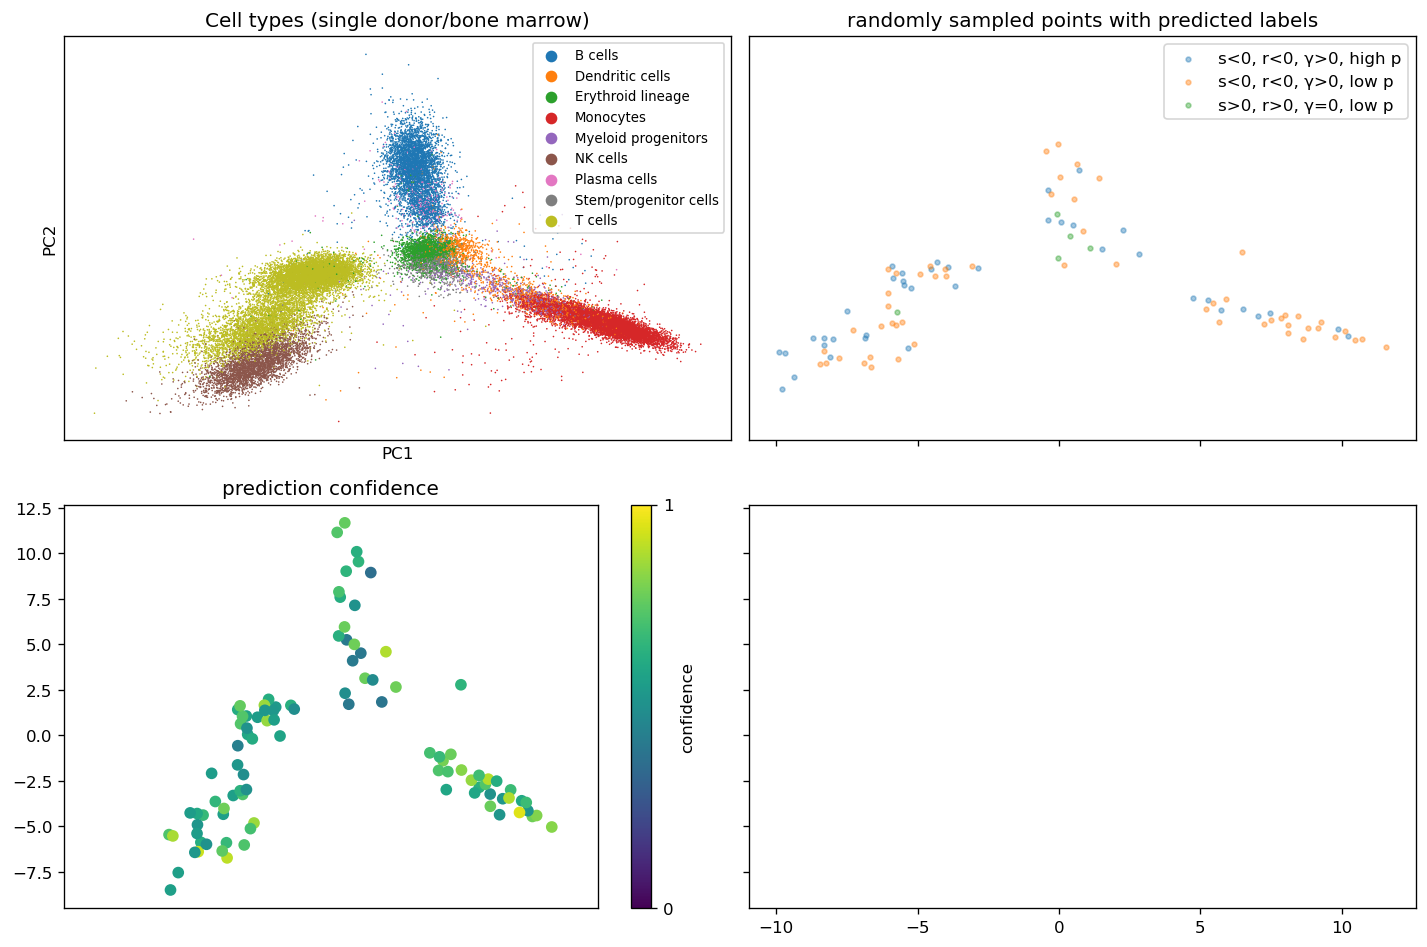

In [19]:
heatmap_data = []
for i, label, confidence_score in zip(chosen_indices, pred_labels, confidence_scores):
    heatmap_data.append([global_state_vecs[i][0], global_state_vecs[i][1], global_state_vecs[i][2], label, confidence_score])

label_color_map = {
    "s<0, r>0, γ=0, high p": "blue",
    "s<0, r>0, γ=0, low p": "purple",
    "s<0, r<0, γ>0, high p": "orange",
    "s<0, r<0, γ>0, low p": "green",
    "s>0, r>0, γ=0, high p": "red",
    "s>0, r>0, γ=0, low p": "brown",
}
fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=120, sharex='col', sharey='row')
for pop_dynamics_label in np.unique([data[3] for data in heatmap_data]):
    PC1, PC2 = [], []
    for data in heatmap_data:
        if data[3] == pop_dynamics_label:
            PC1.append(data[0])
            PC2.append(data[1])
    axes[0,1].scatter(PC1, PC2, alpha=0.4, label=f'{pop_dynamics_label}', s=8)
    axes[0,1].set_title("randomly sampled points with predicted labels")
axes[0,1].legend()
# axes[1].set_ylabel("PC2")

sc.pl.pca(adata_donor, components=['1,2'], color="broad_cell_type", projection="2d", show=False, ax=axes[0, 0])
axes[0,0].set_title("Cell types (single donor/bone marrow)")
axes[0,0].legend(loc='upper right', fontsize=8, markerscale=1)

PC1s, PC2s, cfs = [], [], []
for data in heatmap_data:
    PC1s.append(data[0])
    PC2s.append(data[1])
    cfs.append(data[4])

axes[1,0].set_title("prediction confidence")
im = axes[1,0].scatter(PC1s, PC2s, c=cfs, cmap='viridis')
color_range = [0, 1]
im.set_clim(color_range)
cbar = figure.colorbar(im, ax=axes[1,0])
cbar.ax.set_ylabel('confidence')
cbar.set_ticks(color_range)


plt.tight_layout()
plt.show()